<a href="https://colab.research.google.com/github/kwsk01/machine_learning/blob/main/Bayes/%E7%B5%84%E3%81%BF%E5%90%88%E3%82%8F%E3%81%9B%E3%82%92%E8%80%83%E6%85%AE%E3%81%97%E3%81%9F%E7%B5%B1%E8%A8%88%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt

In [48]:
n = [434,382,394,88]
clicks = [8,17,10,4]

In [45]:
# n = np.random.uniform(100,450)
# p = [0.02,0.04,0.06,0.1]

# #回数を生成
# n = []
# for _ in range(4):
#   n.append(int(np.random.uniform(100,450)))

# A = []
# clicks = []
# #クリック数を生成
# for i in range(4):
#   a = []
#   a.append(n[i])
#   c = np.random.binomial(n[i],p[i])
#   a.append(c)
#   clicks.append(c)
#   A.append(a)
# A

[[402, 8], [437, 17], [230, 15], [423, 56]]

In [46]:
print(n)
print(clicks)

[402, 437, 230, 423]
[8, 17, 15, 56]


## クリックの割合のみ考慮したモデル

$$
  \theta \sim Beta(1,1)\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """


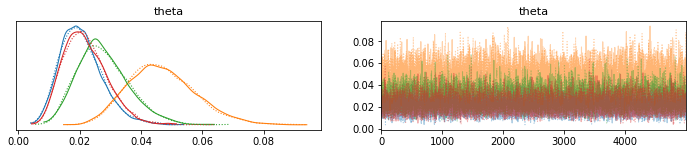

In [66]:
with pm.Model() as model:
  theta = pm.Beta('theta',alpha=1,beta=1,shape=len(n))
  obs = pm.Binomial('obs',p=theta, n=n, observed=clicks)
  trace = pm.sample(5000,chains=2)
  pm.traceplot(trace,compact=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  


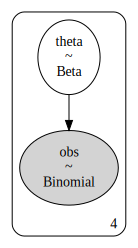

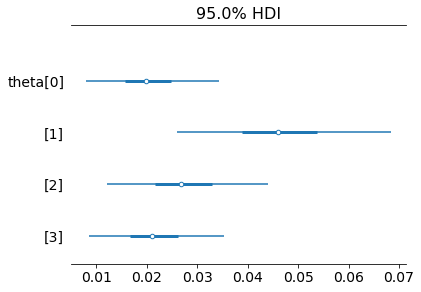

In [67]:
with model:
  pm.forestplot(trace,combined=True,hdi_prob=0.95)
pm.model_to_graphviz(model)

##効果に着目したモデリング

$$
  \alpha \sim Normal(0,10)\\
  \beta_1 \sim Normal(0,10)\\
  \beta_2 \sim Normal(0,10)\\
  \theta = logistic(\alpha + \beta_1 + \beta_2 )\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 26 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  # This is added back by InteractiveShellApp.init_path()


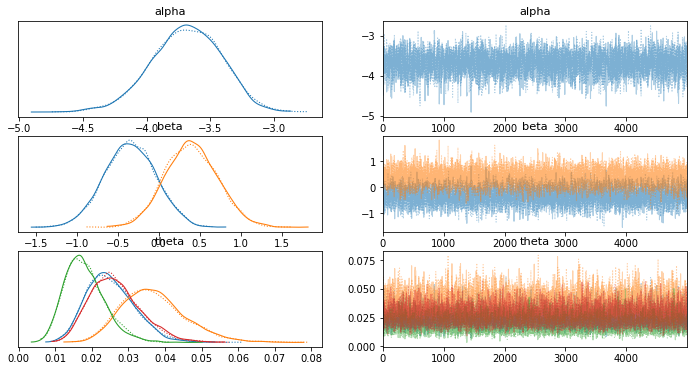

In [59]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_comb:
  alpha = pm.Normal('alpha', mu = 0, sigma=10)
  beta = pm.Normal('beta', mu = 0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb = pm.sample(5000,chains=2)
  pm.traceplot(trace_comb, compact=True)

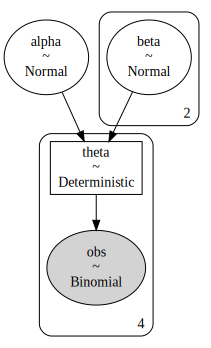

In [60]:
pm.model_to_graphviz(model_comb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  after removing the cwd from sys.path.


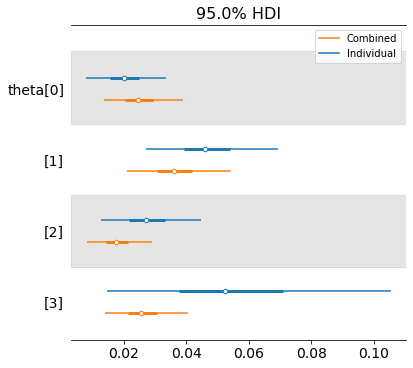

In [61]:
with pm.Model():
  pm.forestplot([trace,trace_comb], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                model_names=['Individual','Combined'])

## 交互作用を加えたモデル

In [62]:
n = [434,382,394,412]
clicks = [8,17,10,8]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  if sys.path[0] == '':


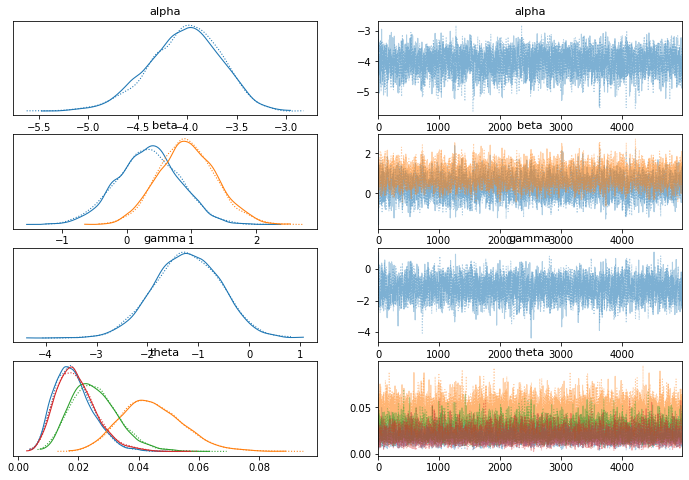

In [63]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_int:#interaction
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  gamma = pm.Normal('gamma', mu=0, sigma=10,)
  comb = alpha + beta[0] * img + beta[1] *btn + gamma * img *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_int = pm.sample(5000,chains=2)
  pm.traceplot(trace_int, compact=True)

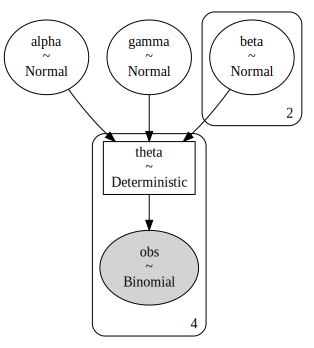

In [64]:
pm.model_to_graphviz(model_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  after removing the cwd from sys.path.


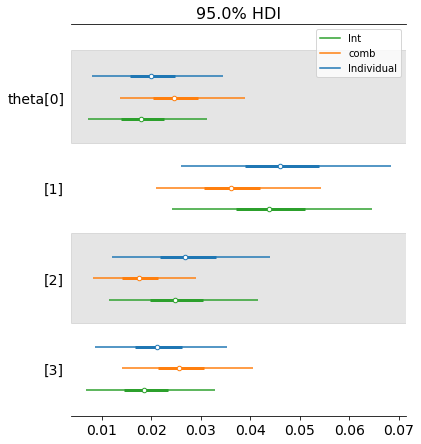

In [68]:
with pm.Model():
  pm.forestplot([trace,trace_comb,trace_int], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                model_names=['Individual','comb','Int'])